In [ ]:
#imoport some packages to use 
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
#To see our directory 
import os 
import random 
import gc #Gabage collector for cleanning data from memory 
from skimage import io, data_dir

from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from scipy.misc import imread
from scipy.misc.pilutil import imread
#from scipy.ndimage import imread
#import scipy.imageio.imread
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras

from tensorflow.keras.layers import Dense
import pandas as pd


from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np


os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
train_dir = 'trainall'
train_imgs = ['trainall/{}'.format(i) for i in os.listdir(train_dir)]
test_dir = 'testall'
test_imgs = ['testall/{}'.format(i) for i in os.listdir(test_dir)]
random.shuffle(train_imgs)
random.shuffle(test_imgs)
length_train = len(train_imgs)
length_test= len(test_imgs)

In [2]:
import matplotlib.image as mpimg
for ima in train_imgs[1000:1003]:
    img = mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

NameError: name 'train_imgs' is not defined

In [3]:
from scipy.misc import imresize
train_img=[]
for i in range(length_train):

    temp_img=image.load_img(train_imgs[i],target_size=(299,299))
    
    temp_img=image.img_to_array(temp_img)

    train_img.append(temp_img)
    
train_img=np.array(train_img) 
train_img=preprocess_input(train_img)

print(type(train_img))
print(train_img.shape)
test_img=[]
for i in range(length_test):

    temp_img=image.load_img(test_imgs[i],target_size=(299,299))

    temp_img=image.img_to_array(temp_img)

    test_img.append(temp_img)
    
test_img=np.array(test_img) 
test_img=preprocess_input(test_img)
print(type(test_img))
print(test_img.shape)

<class 'numpy.ndarray'>
(2281, 299, 299, 3)
<class 'numpy.ndarray'>
(320, 299, 299, 3)


In [2]:
# A function to read and process the images to an acceptable format for our model 
def read_and_process_images(list_of_images):
    #Returns one array
   
    #y is an array of labels
   
    y = [] # labels
    for image in list_of_images:
       
    
        if 'new' in image:
            y.append(1)
        elif 'old' in image:
            y.append(0)
    return y

In [ ]:
train_y = read_and_process_images(train_imgs)
train_y = np.array(train_y)
train_y = np.array(train_y)
train_y=pd.get_dummies(train_y)
train_y=np.array(train_y)
test_y = read_and_process_images(test_imgs)
test_y = np.array(test_y)
test_y = np.array(test_y)
test_y=pd.get_dummies(test_y)
test_y=np.array(test_y)



# Inception

In [3]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model



In [4]:
inception_v3_model = InceptionV3(weights='imagenet', include_top=False)

x = inception_v3_model.output
x= GlobalAveragePooling2D()(x) #  GlobalAveragePooling2D 将 MxNxC 的张量转换成 1xC 张量，C是通道数
x = Dense(1024, activation='relu')(x)

#predictions = Dense(17, activation='softmax')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=inception_v3_model.input, outputs=predictions)
# plot_model(model, 't1mode.png')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [5]:
from keras.optimizers import Adam, RMSprop, SGD

def setup_to_transfer_learning(model, base_model):
    """
    In this method set base_model each layer not trainable.
    """
    for layer in base_model.layers:
        layer.trainable = False
    adam = Adam(lr=0.0001)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    


def setup_to_fine_tune(model, base_model):
    GAP_LAYER=17
    for layer in base_model.layers[:GAP_LAYER+1]:
        layer.trainable = True

    for layer in base_model.layers[GAP_LAYER+1:]:
        layer.trainable = True

   # model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    #adm =Adam(lr=0.0001) 
    sgd = SGD(lr=0.0001)
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
state = np.random.get_state()
np.random.shuffle(train_img)
#print(a)
#result:[6 4 5 3 7 2 0 1 8 9]
np.random.set_state(state)
np.random.shuffle(train_y)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(train_img,train_y,test_size=0.2, shuffle=True,random_state=42)
print(len(X_train))
print(X_train.shape)

# Train inception model 1

In [10]:
from datetime import datetime
start = datetime.now()

#batch_size=64

setup_to_transfer_learning(model, inception_v3_model)


#history = model.fit(X_train, Y_train, epochs=10, batch_size=256,validation_data=(X_valid,Y_valid))

es_callback =tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, Y_train,batch_size=16,epochs=20,shuffle=True,verbose=1,validation_data=(X_valid, Y_valid),callbacks=[es_callback])


#model.save('../data/models/17_flowers_iv3_transfer_learning_model.h5')
end = datetime.now()
print('Traning the Transfer Learning total spend:', (end - start))

Train on 1824 samples, validate on 457 samples
Epoch 1/20
1824/1824 [==============================] - 14s 8ms/step - loss: 0.7065 - acc: 0.6837 - val_loss: 0.5218 - val_acc: 0.7571
Epoch 2/20
1824/1824 [==============================] - 9s 5ms/step - loss: 0.4437 - acc: 0.7988 - val_loss: 0.5824 - val_acc: 0.7155
Epoch 3/20
1824/1824 [==============================] - 10s 5ms/step - loss: 0.4345 - acc: 0.8065 - val_loss: 0.7393 - val_acc: 0.6127
Epoch 4/20
1824/1824 [==============================] - 11s 6ms/step - loss: 0.3854 - acc: 0.8322 - val_loss: 0.5673 - val_acc: 0.7352
Traning the Transfer Learning total spend: 0:00:44.823381


<Figure size 432x288 with 0 Axes>

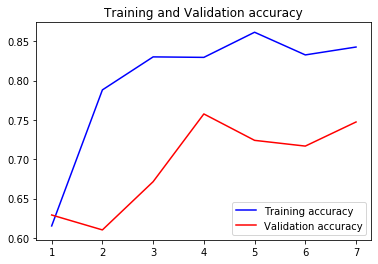

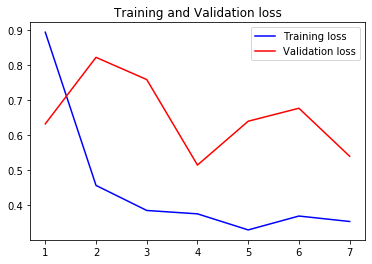

<Figure size 432x288 with 0 Axes>

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']

val_loss = history.history['val_loss']
epochs =  range(1,len(acc)+1)

#train and validation accuracy 
plt.plot(epochs, acc, 'b', label ='Training accuracy')
plt.plot(epochs, val_acc, 'r', label ='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()


#Train and validation loss
plt.plot(epochs, loss, 'b', label ='Training loss')
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()





In [24]:
state = np.random.get_state()
np.random.shuffle(test_img)
#print(a)
#result:[6 4 5 3 7 2 0 1 8 9]
np.random.set_state(state)
np.random.shuffle(test_y)

In [ ]:
score = model.evaluate(test_img, te\st_y, verbose=0)
print(score)

Result one, batch size = 256, vali = 0.2: 0.772

Result two, batch size = 256, vali = 0.3: 0.797

In [ ]:
pred_y=model.predict(test_img)

print(test_img.shape)
print(pred_y.shape)
Y_pred =[]
for i in range(length_test):
    
    if pred_y[i][1] > 0.5:
        Y_pred.append(1)
    else:
        Y_pred.append(0)
    i +=1
    if i == length_test: 
        break

print(type(Y_pred))
Y_pred = np.array(Y_pred)
print(Y_pred.shape)
print(type(Y_pred))
print(Y_pred)
Y_test =[]
for i in range(length_test):
    
    if test_y[i][1] > 0.5:
        Y_test.append(1)
    else:
        Y_test.append(0)
    i +=1
    if i == length_test: 
        break


print(type(Y_test))
Y_test = np.array(Y_test)
print(Y_test.shape)
print(type(Y_test))
print(Y_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,Y_pred)



In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, Y_pred)

array([[ 24, 131],
       [ 20, 145]])

In [46]:
for i in range(length_test):
    if((Y_test[i]==0)and(Y_pred[i]==1)):
        print(i)

3
12
14
20
28
33
46
56
66
81
109
111
118
120
127
130
132
139
150
154
155
162
166
176
181
185
187
188
192
194
208
209
213
215
220
228
239
243
244
262
273
275
280
282
283
284
286
287
294
300
303
307
308
312


# Inception Model 2

In [10]:
from datetime import datetime

start = datetime.now()
setup_to_fine_tune(model, inception_v3_model)
#history = model.fit(X_train, Y_train, epochs=15, batch_size=32,validation_data=(X_valid,Y_valid))

es_callback =tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
history = model.fit(X_train, Y_train,batch_size=16,epochs=20,shuffle=True,verbose=1,validation_data=(X_valid, Y_valid),callbacks=[es_callback])


#model.save('../data/models/17_flowers_iv3_transfer_learning_model.h5')
end = datetime.now()
print('Traning the Fine Tune model:', (end - start))

Train on 1824 samples, validate on 457 samples
Epoch 1/20
1824/1824 [==============================] - 39s 22ms/step - loss: 0.4777 - acc: 0.7736 - val_loss: 0.3974 - val_acc: 0.8403
Epoch 2/20
1824/1824 [==============================] - 28s 16ms/step - loss: 0.2153 - acc: 0.9139 - val_loss: 0.4361 - val_acc: 0.8512
Epoch 3/20
1824/1824 [==============================] - 29s 16ms/step - loss: 0.1021 - acc: 0.9666 - val_loss: 0.4380 - val_acc: 0.8534
Epoch 4/20
1824/1824 [==============================] - 28s 16ms/step - loss: 0.0729 - acc: 0.9792 - val_loss: 0.4088 - val_acc: 0.8643
Epoch 5/20
1824/1824 [==============================] - 28s 16ms/step - loss: 0.0484 - acc: 0.9874 - val_loss: 0.4464 - val_acc: 0.8687
Epoch 6/20
1824/1824 [==============================] - 28s 15ms/step - loss: 0.0330 - acc: 0.9912 - val_loss: 0.4686 - val_acc: 0.8709
Epoch 7/20
1824/1824 [==============================] - 28s 16ms/step - loss: 0.0342 - acc: 0.9879 - val_loss: 0.5594 - val_acc: 0.8578
T

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs =  range(1,len(acc)+1)

#train and validation accuracy 
plt.plot(epochs, acc, 'b', label ='Training accuracy')
plt.plot(epochs, val_acc, 'r', label ='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()


#Train and validation loss
plt.plot(epochs, loss, 'b', label ='Training loss')
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()




In [11]:
score = model.evaluate(test_img, test_y, verbose=0)
print(score)

[0.6085619777441025, 0.8625]


In [22]:
score = model.evaluate(test_img, test_y, verbose=0)
print(score)

[0.6056895613670349, 0.865625]


Result one, epoch = 15, batchsize =32, accuracy = 0.85625，valid = 0.3

Result one, epoch = 15, batchsize =32, accuracy = 0.865625，valid = 0.2

In [124]:
pred_y=model.predict(test_img)

print(test_img.shape)
print(pred_y.shape)


(320, 299, 299, 3)
(320, 2)


In [125]:
Y_pred =[]
for i in range(length_test):
    
    if pred_y[i][1] > 0.5:
        Y_pred.append(0)
    else:
        Y_pred.append(1)
    i +=1
    if i == length_test: 
        break

print(type(Y_pred))
Y_pred = np.array(Y_pred)
print(Y_pred.shape)
print(type(Y_pred))
print(Y_pred)
Y_test =[]
for i in range(length_test):
    
    if test_y[i][1] > 0.5:
        Y_test.append(0)
    else:
        Y_test.append(1)
    i +=1
    if i == length_test: 
        break


print(type(Y_test))
Y_test = np.array(Y_test)
print(Y_test.shape)
print(type(Y_test))
print(Y_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,Y_pred)


<class 'list'>
(320,)
<class 'numpy.ndarray'>
[0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 1
 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 0 1
 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1
 1 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1
 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1
 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1
 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1
 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0 0 1 1 1]
<class 'list'>
(320,)
<class 'numpy.ndarray'>
[0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 1
 0 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 1
 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1
 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 

0.890625

In [126]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, Y_pred)

array([[139,  26],
       [  9, 146]])

# Data Augamentation 

In [4]:
train_dir = 'trainpreview1'
train_imgs = ['trainpreview1/{}'.format(i) for i in os.listdir(train_dir)]
test_dir = 'testall'
test_imgs = ['testall/{}'.format(i) for i in os.listdir(test_dir)]
random.shuffle(train_imgs)
random.shuffle(test_imgs)
length_train = len(train_imgs)
length_test= len(test_imgs)

In [5]:
from scipy.misc import imresize
train_img=[]
for i in range(length_train):

    temp_img=image.load_img(train_imgs[i],target_size=(299,299))
    
    temp_img=image.img_to_array(temp_img)

    train_img.append(temp_img)
    
train_img=np.array(train_img) 
train_img=preprocess_input(train_img)

print(type(train_img))
print(train_img.shape)
test_img=[]
for i in range(length_test):

    temp_img=image.load_img(test_imgs[i],target_size=(299,299))

    temp_img=image.img_to_array(temp_img)

    test_img.append(temp_img)
    
test_img=np.array(test_img) 
test_img=preprocess_input(test_img)
print(type(test_img))
print(test_img.shape)

<class 'numpy.ndarray'>
(20005, 299, 299, 3)
<class 'numpy.ndarray'>
(320, 299, 299, 3)


In [6]:
train_y = read_and_process_images(train_imgs)
print(len(train_y))
print(type(train_y))
train_y = np.array(train_y)
print(len(train_y))
print(type(train_y))
print(train_y.shape)

train_y = np.array(train_y)
train_y=pd.get_dummies(train_y)
train_y=np.array(train_y)
print(type(train_y))
print(train_y.shape)
test_y = read_and_process_images(test_imgs)
print(len(test_y))
print(type(test_y))
test_y = np.array(test_y)
print(len(test_y))
print(type(test_y))
print(test_y.shape)
test_y = np.array(test_y)
test_y=pd.get_dummies(test_y)
test_y=np.array(test_y)
print(type(test_y))
print(test_y.shape)

20005
<class 'list'>
20005
<class 'numpy.ndarray'>
(20005,)
<class 'numpy.ndarray'>
(20005, 2)
320
<class 'list'>
320
<class 'numpy.ndarray'>
(320,)
<class 'numpy.ndarray'>
(320, 2)


In [7]:
inception_v3_model = InceptionV3(weights='imagenet', include_top=False)

x = inception_v3_model.output
x= GlobalAveragePooling2D()(x) #  GlobalAveragePooling2D 将 MxNxC 的张量转换成 1xC 张量，C是通道数
x = Dense(1024, activation='relu')(x)

#predictions = Dense(17, activation='softmax')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=inception_v3_model.input, outputs=predictions)
# plot_model(model, 't1mode.png')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [8]:
from keras.optimizers import Adam, RMSprop, SGD

def setup_to_transfer_learning(model, base_model):
    """
    In this method set base_model each layer not trainable.
    """
    for layer in base_model.layers:
        layer.trainable = False
    sgd = SGD(lr=0.0001)
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    #adam = Adam(lr=0.0001)
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
def setup_to_fine_tune(model, base_model):
    GAP_LAYER=17
    for layer in base_model.layers[:GAP_LAYER+1]:
        layer.trainable = True

    for layer in base_model.layers[GAP_LAYER+1:]:
        layer.trainable = True

   # model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    #adm =Adam(lr=0.0001) 
    sgd = SGD(lr=0.0001)
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])



In [9]:
state = np.random.get_state()
np.random.shuffle(test_img)
#print(a)
#result:[6 4 5 3 7 2 0 1 8 9]
np.random.set_state(state)
np.random.shuffle(test_y)

In [10]:
state = np.random.get_state()
np.random.shuffle(train_img)
#print(a)
#result:[6 4 5 3 7 2 0 1 8 9]
np.random.set_state(state)
np.random.shuffle(train_y)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(train_img,train_y,test_size=0.10,shuffle=True,random_state=42)
print(len(X_train))
print(X_train.shape)

18004
(18004, 299, 299, 3)


# Inception Model 1

In [ ]:
from datetime import datetime
start = datetime.now()

#batch_size=64

setup_to_transfer_learning(model, inception_v3_model)


#history = model.fit(X_train, Y_train, epochs=10, batch_size=256,validation_data=(X_valid,Y_valid))

es_callback =tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0)
history = model.fit(X_train, Y_train,batch_size=32,epochs=10,shuffle=True,verbose=1,validation_data=(X_valid, Y_valid),callbacks=[es_callback])



#history = model.fit(X_train, Y_train, epochs=15, batch_size=,validation_data=(X_valid,Y_valid))


#model.save('../data/models/17_flowers_iv3_transfer_learning_model.h5')
end = datetime.now()
print('Traning the Transfer Learning total spend:', (end - start))

In [ ]:
score = model.evaluate(test_img, test_y, verbose=0)
print(score)

 0.78125

0.75625

8, 0.740625

batch=32, 0.728125

batch = 64. 0.753125

batch=32,0.7219

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs =  range(1,len(acc)+1)

#train and validation accuracy 
plt.plot(epochs, acc, 'b', label ='Training accuracy')
plt.plot(epochs, val_acc, 'r', label ='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()


#Train and validation loss
plt.plot(epochs, loss, 'b', label ='Training loss')
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()



In [19]:
pred_y=model.predict(test_img)

print(test_img.shape)
print(pred_y.shape)

(320, 299, 299, 3)
(320, 2)


In [ ]:
pred_y=model.predict(test_img)

print(test_img.shape)
print(pred_y.shape)
Y_pred =[]
for i in range(length_test):
    
    if pred_y[i][1] > 0.5:
        Y_pred.append(0)
    else:
        Y_pred.append(1)
    i +=1
    if i == length_test: 
        break

print(type(Y_pred))
Y_pred = np.array(Y_pred)
print(Y_pred.shape)
print(type(Y_pred))
print(Y_pred)
Y_test =[]
for i in range(length_test):
    
    if test_y[i][1] > 0.5:
        Y_test.append(0)
    else:
        Y_test.append(1)
    i +=1
    if i == length_test: 
        break


print(type(Y_test))
Y_test = np.array(Y_test)
print(Y_test.shape)
print(type(Y_test))
print(Y_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,Y_pred)




In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, Y_pred)

# Inception model 2

In [12]:
from datetime import datetime
start = datetime.now()
setup_to_fine_tune(model, inception_v3_model)

es_callback =tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
history = model.fit(X_train, Y_train,batch_size=16,epochs=20,shuffle=True,verbose=1,validation_data=(X_valid, Y_valid),callbacks=[es_callback])




#history = model.fit(X_train, Y_train, epochs=2, batch_size=32,validation_data=(X_valid,Y_valid))


#model.save('../data/models/17_flowers_iv3_transfer_learning_model.h5')
end = datetime.now()
print('Traning the Fine Tune model:', (end - start))

Train on 8208 samples, validate on 913 samples
Epoch 1/20
8208/8208 [==============================] - 136s 17ms/step - loss: 0.3407 - acc: 0.8525 - val_loss: 0.2388 - val_acc: 0.9036
Epoch 2/20
8208/8208 [==============================] - 124s 15ms/step - loss: 0.1123 - acc: 0.9559 - val_loss: 0.1815 - val_acc: 0.9255
Epoch 3/20
8208/8208 [==============================] - 124s 15ms/step - loss: 0.0616 - acc: 0.9777 - val_loss: 0.1005 - val_acc: 0.9595
Epoch 4/20
8208/8208 [==============================] - 124s 15ms/step - loss: 0.0357 - acc: 0.9867 - val_loss: 0.0861 - val_acc: 0.9726
Epoch 5/20
8208/8208 [==============================] - 123s 15ms/step - loss: 0.0327 - acc: 0.9893 - val_loss: 0.1110 - val_acc: 0.9595
Traning the Fine Tune model: 0:10:36.318976


In [61]:
state = np.random.get_state()
np.random.shuffle(test_img)
#print(a)
#result:[6 4 5 3 7 2 0 1 8 9]
np.random.set_state(state)
np.random.shuffle(test_y)

In [51]:
score = model.evaluate(test_img, test_y, verbose=0)
print(score)

[0.8807771876454353, 0.875]


In [13]:
score = model.evaluate(test_img, test_y, verbose=0)
print(score)

[0.5724588073790073, 0.86875]


Result two: batchsize = 16, epochs = 5, valid = 0.1, accuracy = 0.868

Result one: batchsize = 32, epochs = 3, valid = 0.1, accuracy = 0.84375

Result two: batchsize = 64, epochs = 4, valid = 0.1, accuracy = 0.853125

In [147]:
score = model.evaluate(test_img, test_y, verbose=0)
print(score)

[0.741431912779808, 0.875]


In [22]:
score = model.evaluate(test_img, test_y, verbose=0)
print(score)

[0.8343449383974075, 0.871875]


<Figure size 432x288 with 0 Axes>

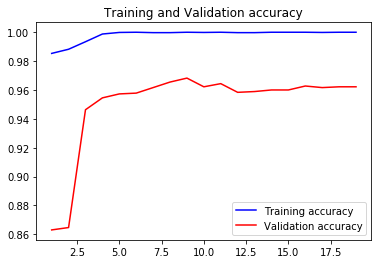

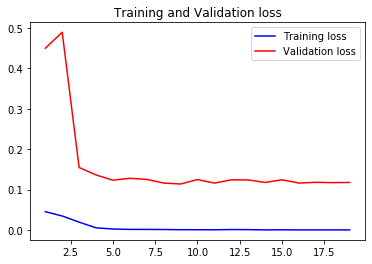

<Figure size 432x288 with 0 Axes>

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs =  range(1,len(acc)+1)

#train and validation accuracy 
plt.plot(epochs, acc, 'b', label ='Training accuracy')
plt.plot(epochs, val_acc, 'r', label ='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()


#Train and validation loss
plt.plot(epochs, loss, 'b', label ='Training loss')
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()




In [134]:
pred_y=model.predict(test_img)

print(test_img.shape)
print(pred_y.shape)
Y_pred =[]
for i in range(length_test):
    
    if pred_y[i][1] > 0.5:
        Y_pred.append(1)
    else:
        Y_pred.append(0)
    i +=1
    if i == length_test: 
        break

print(type(Y_pred))
Y_pred = np.array(Y_pred)
print(Y_pred.shape)
print(type(Y_pred))
print(Y_pred)
Y_test =[]
for i in range(length_test):
    
    if test_y[i][1] > 0.5:
        Y_test.append(1)
    else:
        Y_test.append(0)
    i +=1
    if i == length_test: 
        break


print(type(Y_test))
Y_test = np.array(Y_test)
print(Y_test.shape)
print(type(Y_test))
print(Y_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,Y_pred)





(320, 299, 299, 3)
(320, 2)
<class 'list'>
(320,)
<class 'numpy.ndarray'>
[0 1 1 1 1 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1
 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1
 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0
 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 0 0
 1 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1
 0 0 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 1
 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1
 0 0 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1]
<class 'list'>
(320,)
<class 'numpy.ndarray'>
[0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1
 1 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1
 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0
 1 1 

0.85

In [135]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, Y_pred)

array([[127,  28],
       [ 20, 145]])

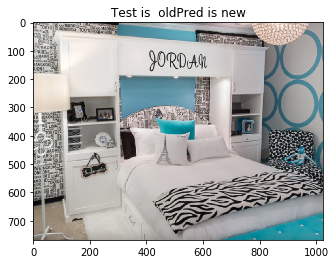

25


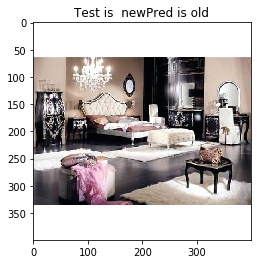

27


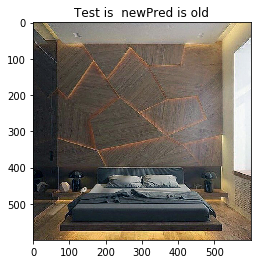

38


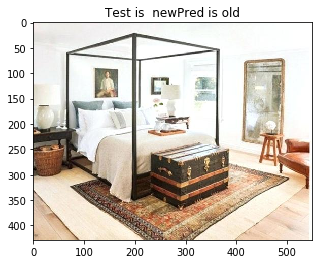

60


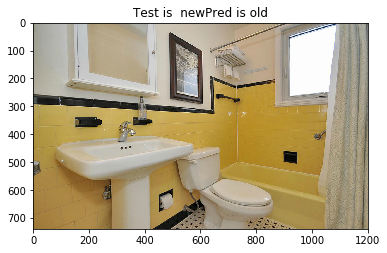

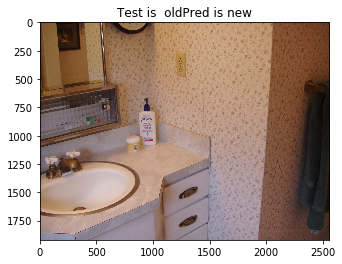

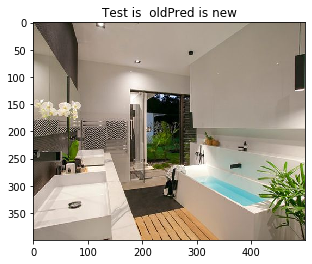

77


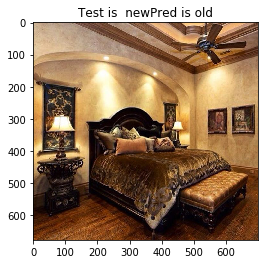

80


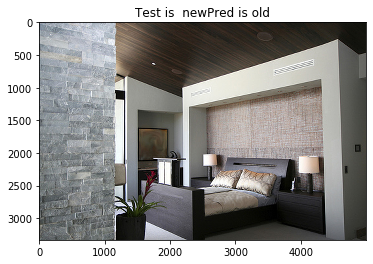

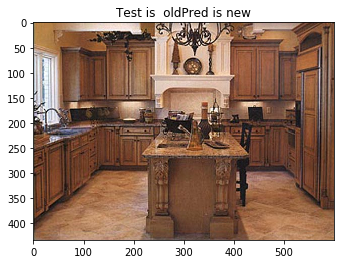

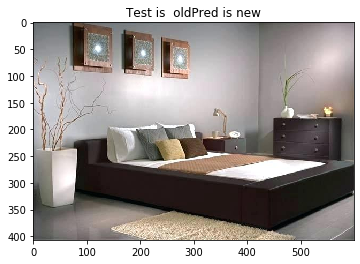

102


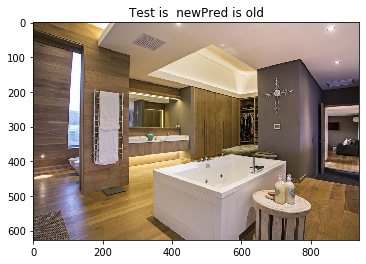

104


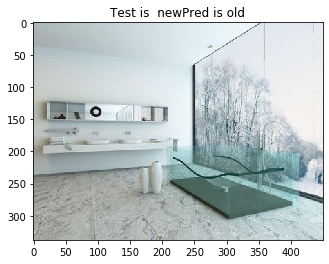

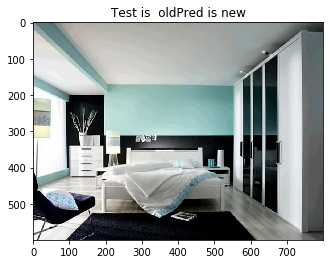

110


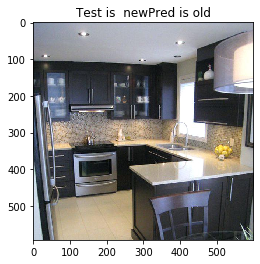

112


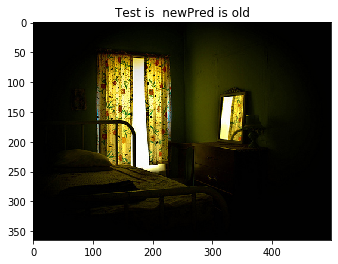

113


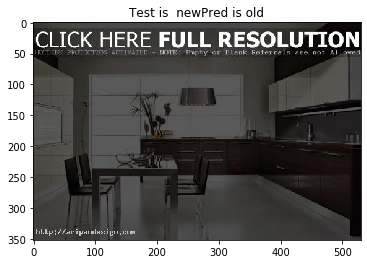

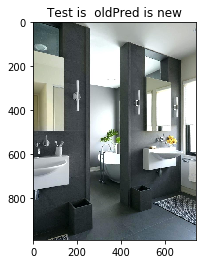

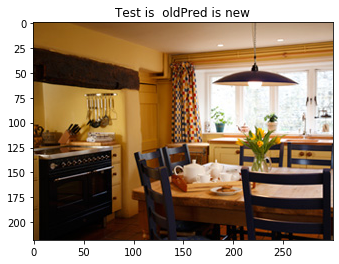

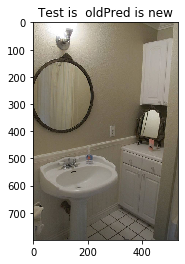

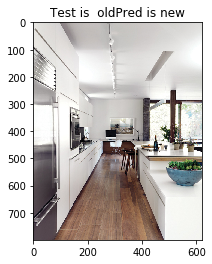

137


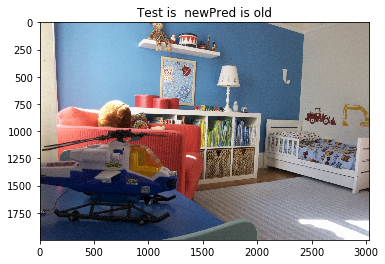

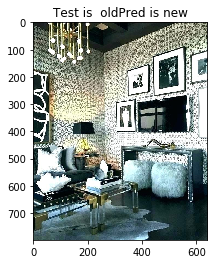

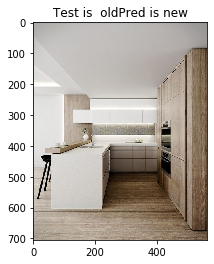

158


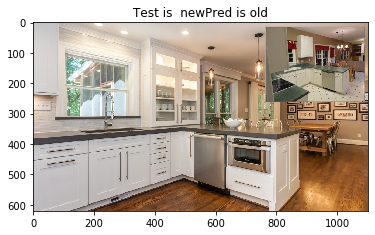

159


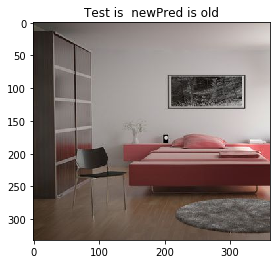

165


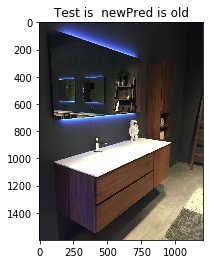

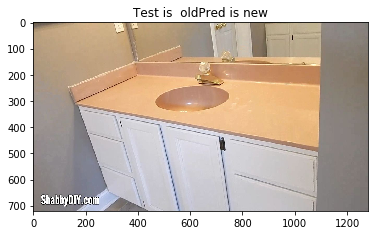

171


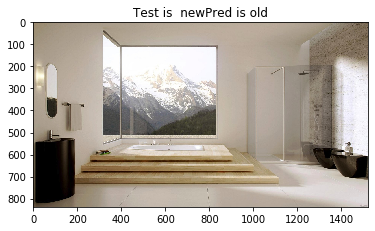

172


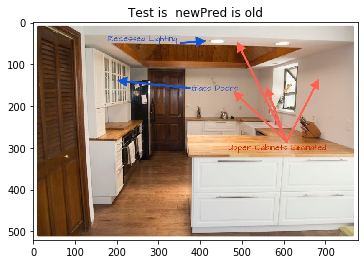

175


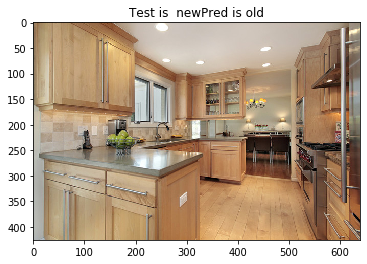

179


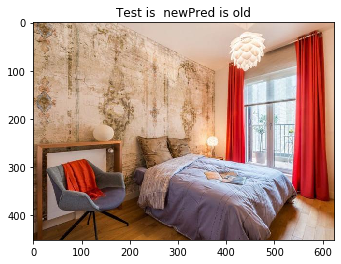

199


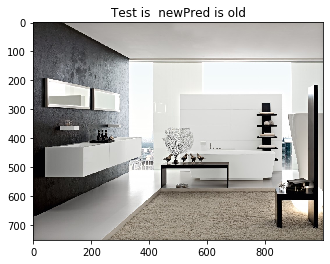

208


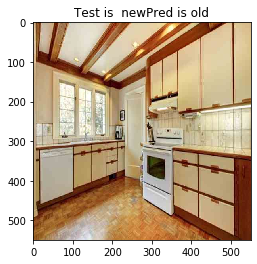

222


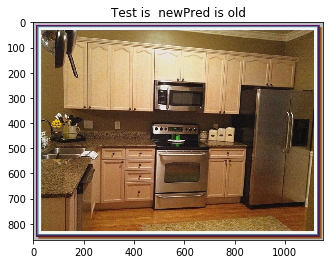

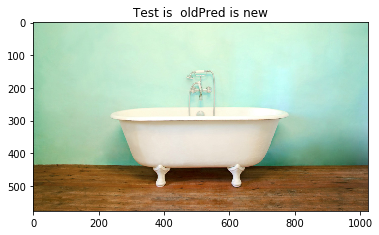

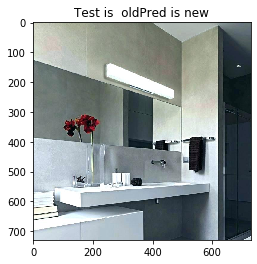

233


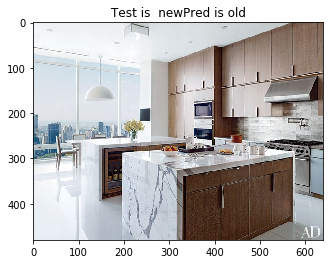

238


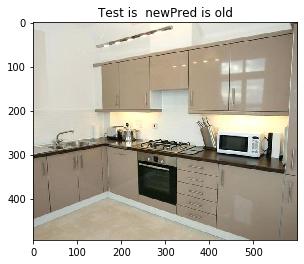

250


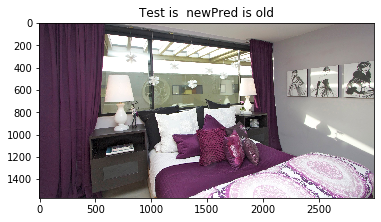

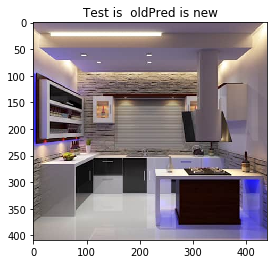

270


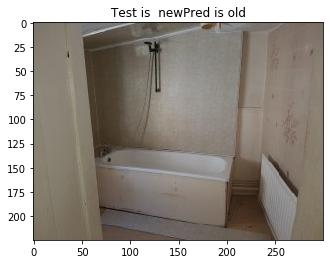

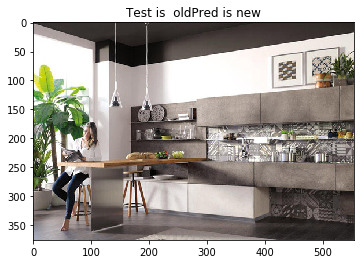

283


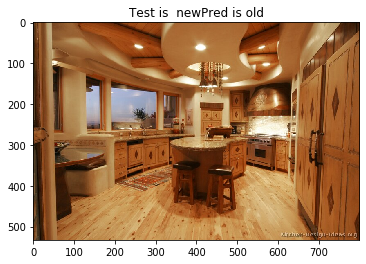

295


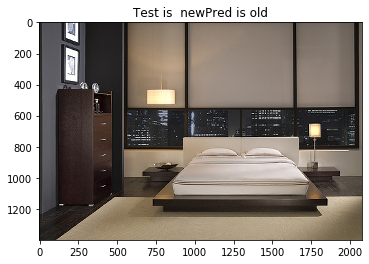

298


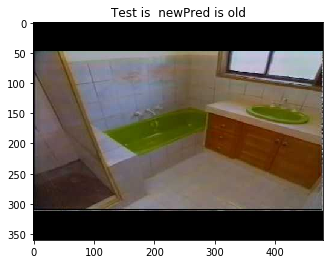

301


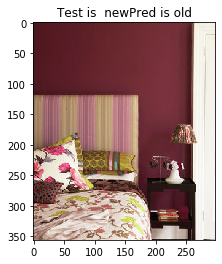

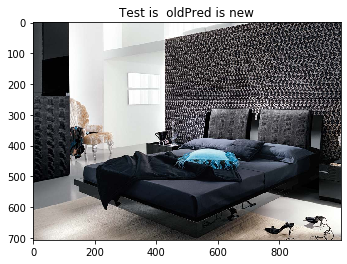

319


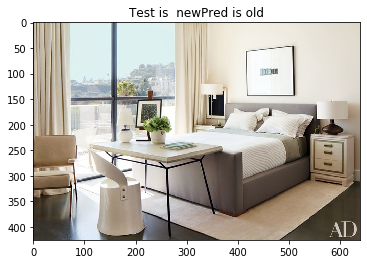

49


In [65]:
import matplotlib.image as mpimg
i = 0 
j=0
text_labels = []
pred_labels = []
for ima in test_imgs:
    
    if(Y_test[i]!=Y_pred[i]):
        
        img = mpimg.imread(ima)
        if Y_test[i] > 0.5:
            text_labels.append('new')
            print(i)
        else:
            text_labels.append('old')
        if Y_pred[i] > 0.5:
            pred_labels.append('new')
        else:
            pred_labels.append('old')
        
        
        plt.title('Test is  ' + text_labels[j] + 'Pred is '+ pred_labels[j])
        imgplot = plt.imshow(img)
        j+=1
        plt.show()
    i+=1
print(j)

# Data 2

In [6]:
train_dir = 'trainpreview1'
train_imgs = ['trainpreview1/{}'.format(i) for i in os.listdir(train_dir)]
test_dir = 'testall'
test_imgs = ['testall/{}'.format(i) for i in os.listdir(test_dir)]
random.shuffle(train_imgs)
random.shuffle(test_imgs)
length_train = len(train_imgs)
length_test= len(test_imgs)

In [7]:
from scipy.misc import imresize
train_img=[]
for i in range(length_train):

    temp_img=image.load_img(train_imgs[i],target_size=(299,299))
    
    temp_img=image.img_to_array(temp_img)

    train_img.append(temp_img)
    
train_img=np.array(train_img) 
train_img=preprocess_input(train_img)

print(type(train_img))
print(train_img.shape)
test_img=[]
for i in range(length_test):

    temp_img=image.load_img(test_imgs[i],target_size=(299,299))

    temp_img=image.img_to_array(temp_img)

    test_img.append(temp_img)
    
test_img=np.array(test_img) 
test_img=preprocess_input(test_img)
print(type(test_img))
print(test_img.shape)

<class 'numpy.ndarray'>
(20005, 299, 299, 3)
<class 'numpy.ndarray'>
(320, 299, 299, 3)


In [8]:
train_y = read_and_process_images(train_imgs)
print(len(train_y))
print(type(train_y))
train_y = np.array(train_y)
print(len(train_y))
print(type(train_y))
print(train_y.shape)
train_y = np.array(train_y)
train_y=pd.get_dummies(train_y)
train_y=np.array(train_y)
print(type(train_y))
print(train_y.shape)
test_y = read_and_process_images(test_imgs)
print(len(test_y))
print(type(test_y))
test_y = np.array(test_y)
print(len(test_y))
print(type(test_y))
print(test_y.shape)
test_y = np.array(test_y)
test_y=pd.get_dummies(test_y)
test_y=np.array(test_y)
print(type(test_y))
print(test_y.shape)

20005
<class 'list'>
20005
<class 'numpy.ndarray'>
(20005,)
<class 'numpy.ndarray'>
(20005, 2)
320
<class 'list'>
320
<class 'numpy.ndarray'>
(320,)
<class 'numpy.ndarray'>
(320, 2)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(train_img,train_y,test_size=0.05, random_state=42)
print(len(X_train))
print(X_train.shape)

19004
(19004, 299, 299, 3)


In [17]:
del train_img
del train_y
del train_imgs 
gc.collect()

16

In [18]:
del test_imgs

# Inception Model 2

In [16]:
from datetime import datetime
start = datetime.now()
setup_to_fine_tune(model, inception_v3_model)
#history = model.fit(X_train, Y_train, epochs=2, batch_size=32,validation_data=(X_valid,Y_valid))

es_callback =tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
history = model.fit(X_train, Y_train,batch_size=16,epochs=20,shuffle=True,verbose=1,validation_data=(X_valid, Y_valid),callbacks=[es_callback])
#model.save('../data/models/17_flowers_iv3_transfer_learning_model.h5')
end = datetime.now()
print('Traning the Fine Tune model:', (end - start))

Train on 19004 samples, validate on 1001 samples
Epoch 1/20
19004/19004 [==============================] - 299s 16ms/step - loss: 3.5983e-04 - acc: 0.9999 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 2/20
19004/19004 [==============================] - 285s 15ms/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0058 - val_acc: 0.9970
Traning the Fine Tune model: 0:09:52.001874


In [17]:
score = model.evaluate(test_img, test_y, verbose=0)
print(score)

[0.8608123354613781, 0.875]


In [12]:
score = model.evaluate(test_img, test_y, verbose=0)
print(score)

[0.8226198881864548, 0.875]


In [27]:
score = model.evaluate(test_img, test_y, verbose=0)
print(score)

[0.8306667983531952, 0.878125]


<Figure size 432x288 with 0 Axes>

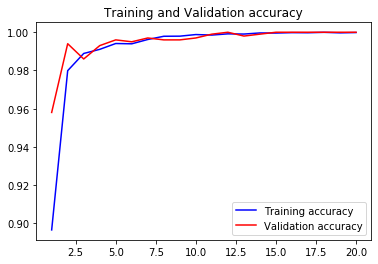

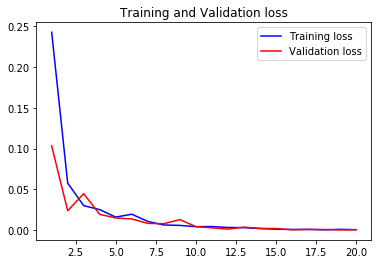

<Figure size 432x288 with 0 Axes>

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs =  range(1,len(acc)+1)

#train and validation accuracy 
plt.plot(epochs, acc, 'b', label ='Training accuracy')
plt.plot(epochs, val_acc, 'r', label ='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()


#Train and validation loss
plt.plot(epochs, loss, 'b', label ='Training loss')
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()



In [22]:
pred_y=model.predict(test_img)

print(test_img.shape)
print(pred_y.shape)
Y_pred =[]
for i in range(length_test):
    
    if pred_y[i][1] > 0.5:
        Y_pred.append(1)
    else:
        Y_pred.append(0)
    i +=1
    if i == length_test: 
        break

print(type(Y_pred))
Y_pred = np.array(Y_pred)
print(Y_pred.shape)
print(type(Y_pred))
print(Y_pred)
Y_test =[]
for i in range(length_test):
    
    if test_y[i][1] > 0.5:
        Y_test.append(1)
    else:
        Y_test.append(0)
    i +=1
    if i == length_test: 
        break


print(type(Y_test))
Y_test = np.array(Y_test)
print(Y_test.shape)
print(type(Y_test))
print(Y_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,Y_pred)






(320, 299, 299, 3)
(320, 2)
<class 'list'>
(320,)
<class 'numpy.ndarray'>
[0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0
 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0
 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1
 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1
 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1
 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 1
 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0
 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 1]
<class 'list'>
(320,)
<class 'numpy.ndarray'>
[0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0
 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1
 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0
 1 0 

0.865625

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, Y_pred)

array([[128,  27],
       [ 16, 149]])